# WeatherPy
----

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
try:
    from citipy import citipy
except:
    !pip install citipy
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

ModuleNotFoundError: No module named 'api_keys'

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f'There are {len(cities)} cities in this list.')
print(f'It will take a little more than {round(len(cities)/60, 2)} minutes to ping the server for all cities.')

There are 587 cities in this list.
It will take a little more than 9.78 minutes to ping the server for all cities.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
openweathermap_url = 'https://api.openweathermap.org/'

def get_current_weather_data(q, appid, mode=None, units=None, lang=None):
    """
    get the current weather data from openweathermap
    returns a get request with the provided data
    
    Parameters
    ----------
        q — City name, state code and country code divided by comma, use ISO 3166 country codes. You can specify the parameter not only in English. In this case, the API response should be returned in the same language as the language of requested location name if the location is in our predefined list of more than 200,000 locations.
        appid — Your unique API key
        mode — Response format. Possible values are xml and html. If you don't use the mode parameter format is JSON by default.
        units — Units of measurement. standard, metric and imperial units are available. If you do not use the units parameter, standard units will be applied by default.
        lang — You can use this parameter to get the output in your language.
    """
    payload = {
        'q' : q,
        'appid' : appid
    }
    if mode: params['mode'] = mode
    if units: params['units'] = units
    if lang: params['lang'] = lang
    time.sleep(1)
    return requests.get(openweathermap_url + 'data/2.5/weather', params=payload)

In [4]:
def filter_city_data(city_data):
    """
    Convert the raw city json data into a the useable info we need
    returns a dictionary
        
    Parameters
    ----------
        data — The original dataframe to filter from
    """
    return {
        'City_ID' : city_data['id'],
        'City' : city_data['name'],
        'Cloudiness' : city_data['clouds']['all'],
        'Country' : city_data['sys']['country'],
        'Date' : city_data['dt'],
        'Humidity' : city_data['main']['humidity'],
        'Lat' : city_data['coord']['lat'],
        'Lng' : city_data['coord']['lon'],
        # pull out temps and convert from kelvin to fahrenheit
        'Min Temp' : float(city_data['main']['temp_min']) * (9/5) - 459.67,
        'Max Temp' : float(city_data['main']['temp_max']) * (9/5) - 459.67,
        'Wind Speed' : city_data['main']['humidity']
    }

In [5]:
def convert_cities_to_dataframe(cities):
    """
    Convert the list of cities names into a dataframe using the open weather map api
    returns a DataFrame
    
    Parameters
    ----------
        cities — The list of cities to use
    """
    df = pd.DataFrame()
    # if there are no cities, exit
    if len(cities) < 1: return df
    for city in cities:
        # print status
        status = f'{(cities.index(city) + 1)} of {len(cities)}'
        print(f'({status}) pinging server for city {city}')
        try:
            request = get_current_weather_data(city, weather_api_key)
            # if request fails, exit
            if request.status_code != 200:
                print(f'\tCould not find city {city}, error {request.status_code}')
                continue
            # convert the json into the raw city data
            raw_city_data = filter_city_data(request.json())
            city_df = pd.DataFrame(raw_city_data, index=[0])
            # add the dataset
            df = pd.concat([df, city_df])
        except Exception as e:
            print(f'Error - could not ping city {city}, ERROR: {e}')
    # convert the time data
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    return df.reset_index(drop=True)

df = convert_cities_to_dataframe(cities)

(1 of 587) pinging server for city aklavik
(2 of 587) pinging server for city glomfjord
(3 of 587) pinging server for city neiafu
(4 of 587) pinging server for city punta arenas
(5 of 587) pinging server for city popondetta
(6 of 587) pinging server for city gumushane
	Could not find city gumushane, error 404
(7 of 587) pinging server for city samana
(8 of 587) pinging server for city vaini
(9 of 587) pinging server for city rikitea
(10 of 587) pinging server for city norman wells
(11 of 587) pinging server for city provideniya
(12 of 587) pinging server for city qaqortoq
(13 of 587) pinging server for city cochrane
(14 of 587) pinging server for city cockburn town
(15 of 587) pinging server for city leningradskiy
(16 of 587) pinging server for city verkhoyansk
(17 of 587) pinging server for city kaitangata
(18 of 587) pinging server for city ushuaia
(19 of 587) pinging server for city sentyabrskiy
	Could not find city sentyabrskiy, error 404
(20 of 587) pinging server for city poum
(2

(167 of 587) pinging server for city pinsk
(168 of 587) pinging server for city villamontes
(169 of 587) pinging server for city talnakh
(170 of 587) pinging server for city arlington
(171 of 587) pinging server for city lamas
(172 of 587) pinging server for city los llanos de aridane
(173 of 587) pinging server for city qaanaaq
(174 of 587) pinging server for city christchurch
(175 of 587) pinging server for city pangnirtung
(176 of 587) pinging server for city san cristobal
(177 of 587) pinging server for city hualmay
(178 of 587) pinging server for city mogadishu
(179 of 587) pinging server for city devyatka
	Could not find city devyatka, error 404
(180 of 587) pinging server for city jalu
(181 of 587) pinging server for city malanje
(182 of 587) pinging server for city ribeira grande
(183 of 587) pinging server for city bani
(184 of 587) pinging server for city luau
(185 of 587) pinging server for city rairangpur
(186 of 587) pinging server for city dolores
(187 of 587) pinging ser

(330 of 587) pinging server for city prieska
(331 of 587) pinging server for city mount gambier
(332 of 587) pinging server for city attawapiskat
	Could not find city attawapiskat, error 404
(333 of 587) pinging server for city namatanai
(334 of 587) pinging server for city bonavista
(335 of 587) pinging server for city marsh harbour
(336 of 587) pinging server for city kita
(337 of 587) pinging server for city airai
(338 of 587) pinging server for city tommot
(339 of 587) pinging server for city sur
(340 of 587) pinging server for city udachnyy
(341 of 587) pinging server for city rio formoso
(342 of 587) pinging server for city fort nelson
(343 of 587) pinging server for city conneaut
(344 of 587) pinging server for city santiago del estero
(345 of 587) pinging server for city skibbereen
(346 of 587) pinging server for city alotau
	Could not find city alotau, error 404
(347 of 587) pinging server for city bilma
(348 of 587) pinging server for city saint george
(349 of 587) pinging se

(498 of 587) pinging server for city bondo
(499 of 587) pinging server for city guarapari
(500 of 587) pinging server for city cananeia
(501 of 587) pinging server for city santa maria
(502 of 587) pinging server for city springbok
(503 of 587) pinging server for city davila
(504 of 587) pinging server for city port pirie
(505 of 587) pinging server for city acapulco
(506 of 587) pinging server for city port keats
(507 of 587) pinging server for city sulangan
(508 of 587) pinging server for city manakara
(509 of 587) pinging server for city saint-joseph
(510 of 587) pinging server for city oksovskiy
(511 of 587) pinging server for city ewa beach
(512 of 587) pinging server for city havre-saint-pierre
(513 of 587) pinging server for city havoysund
(514 of 587) pinging server for city pochutla
(515 of 587) pinging server for city paso de patria
(516 of 587) pinging server for city honiara
(517 of 587) pinging server for city quebo
(518 of 587) pinging server for city odienne
(519 of 587)

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
df.to_csv('../output_data/cities.csv', index = False, header=True)
df

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,5882953,Aklavik,100,CA,2021-02-08 00:18:04,76,68.2191,-135.0107,-23.800,-22.000,76
1,3155487,Glomfjord,40,NO,2021-02-08 00:21:08,64,66.8167,13.9667,12.002,28.994,64
2,4032420,Neiafu,75,TO,2021-02-08 00:21:09,94,-18.6500,-173.9833,77.000,77.000,94
3,3874787,Punta Arenas,90,CL,2021-02-08 00:21:10,34,-53.1500,-70.9167,66.200,66.200,34
4,2088163,Popondetta,100,PG,2021-02-08 00:21:11,86,-8.7537,148.2534,80.078,80.078,86
...,...,...,...,...,...,...,...,...,...,...,...
541,1684245,Tagusao,97,PH,2021-02-08 00:33:17,78,9.1924,117.8141,81.518,81.518,78
542,3723593,Jérémie,27,HT,2021-02-08 00:33:19,71,18.6500,-74.1167,76.982,76.982,71
543,5975004,High Level,20,CA,2021-02-08 00:33:20,63,58.5169,-117.1360,-16.600,-16.600,63
544,2063036,Port Lincoln,58,AU,2021-02-08 00:33:21,71,-34.7333,135.8667,64.220,64.220,71


In [9]:
df.describe()

,City_ID,Cloudiness,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
count,5.460000e+02,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,2.830105e+06,52.346154,73.344322,17.800426,13.321158,49.076363,50.092835,73.344322
std,1.744312e+06,39.458992,18.712272,34.085280,90.819447,33.107770,33.043547,18.712272
min,5.315700e+04,0.000000,10.000000,-54.800000,-175.200000,-36.940000,-36.940000,10.000000
25%,1.529528e+06,11.000000,65.000000,-11.312625,-64.035475,26.694500,29.246000,65.000000
50%,2.372528e+06,49.000000,77.000000,18.667650,16.853500,62.798000,63.815000,77.000000
75%,3.691861e+06,93.000000,86.000000,46.966500,86.168050,75.375500,76.964000,86.000000
max,1.072286e+07,100.000000,100.000000,78.218600,179.316700,87.800000,89.600000,100.000000


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [4]:
too_humid_df = df.loc[df['Humidity'] > 100]
if too_humid_df.size < 1:
    print('There are no cities with humidity higher than 100%')
else: too_humid_df

There are no cities with humidity higher than 100%


In [5]:
#  Get the indices of cities that have humidity over 100%.
too_humid_df.index

Int64Index([], dtype='int64')

In [6]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = pd.DataFrame(df)

if too_humid_df.size > 0:
    clean_city_data = df.drop(too_humid_df.index, axis=0, inplace=False)

clean_city_data.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,5882953,Aklavik,100,CA,2021-02-08 00:18:04,76,68.2191,-135.0107,-23.800,-22.000,76
1,3155487,Glomfjord,40,NO,2021-02-08 00:21:08,64,66.8167,13.9667,12.002,28.994,64
2,4032420,Neiafu,75,TO,2021-02-08 00:21:09,94,-18.6500,-173.9833,77.000,77.000,94
3,3874787,Punta Arenas,90,CL,2021-02-08 00:21:10,34,-53.1500,-70.9167,66.200,66.200,34
4,2088163,Popondetta,100,PG,2021-02-08 00:21:11,86,-8.7537,148.2534,80.078,80.078,86


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [34]:
def plot_the_data(x, y, x_label, y_label, title, output_file):
    """
    Plotting the Data and save the plotted figures as .pngs
        
    Parameters
    ----------
        x — The x axis data
        y — The y axis data
        x_label — The label for the x axis data
        y_label — The label for the y axis data
        title — The title for the plot
        output_file — The name of the saved output file
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, ls=' ', marker='o', color='b', markeredgecolor="black", alpha=0.66)
    ax.set_title(f'{title} ({time.strftime("%m/%d/%y")})', fontsize=(12))
    ax.set_xlabel(x_label, fontsize=(12))
    ax.set_ylabel(y_label, fontsize=(12))
    plt.grid(True)
    plt.tight_layout
    plt.savefig('../Images/' + output_file + '.png')
    plt.show()

## Latitude vs. Temperature Plot

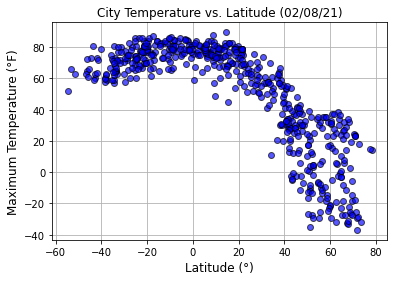

In [35]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Max Temp'],
    'Latitude (°)',
    'Maximum Temperature (°F)', 
    'City Temperature vs. Latitude',
    'Cities_TempVLat'
)

## Latitude vs. Humidity Plot

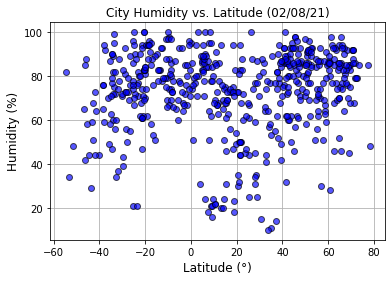

In [36]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Humidity'],
    'Latitude (°)',
    'Humidity (%)', 
    'City Humidity vs. Latitude',
    'Cities_HumidityVLat'
)

## Latitude vs. Cloudiness Plot

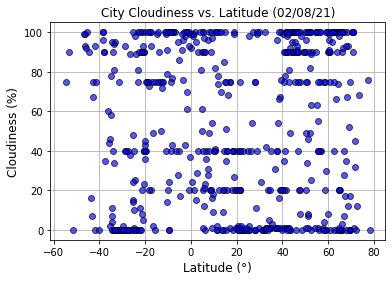

In [37]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Cloudiness'],
    'Latitude (°)',
    'Cloudiness (%)', 
    'City Cloudiness vs. Latitude',
    'Cities_CloudinessVLat'
)

## Latitude vs. Wind Speed Plot

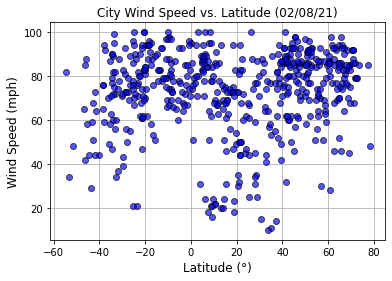

In [38]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Wind Speed'],
    'Latitude (°)',
    'Wind Speed (mph)', 
    'City Wind Speed vs. Latitude',
    'Cities_WindSpeedVLat'
)

## Linear Regression

In [39]:
n_hemisphere_df = clean_city_data.loc[clean_city_data['Lat'] > 0]
n_hemisphere_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,5882953,Aklavik,100,CA,2021-02-08 00:18:04,76,68.2191,-135.0107,-23.800,-22.000,76
1,3155487,Glomfjord,40,NO,2021-02-08 00:21:08,64,66.8167,13.9667,12.002,28.994,64
5,3492997,Samaná,20,DO,2021-02-08 00:21:14,83,19.2056,-69.3369,78.800,78.800,83
8,6089245,Norman Wells,20,CA,2021-02-08 00:21:17,75,65.2820,-126.8329,-27.400,-27.400,75
9,4031574,Provideniya,74,RU,2021-02-08 00:21:19,83,64.3833,-173.3000,-0.544,-0.544,83


In [40]:
s_hemisphere_df = clean_city_data.loc[clean_city_data['Lat'] < 0]
s_hemisphere_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
2,4032420,Neiafu,75,TO,2021-02-08 00:21:09,94,-18.6500,-173.9833,77.000,77.000,94
3,3874787,Punta Arenas,90,CL,2021-02-08 00:21:10,34,-53.1500,-70.9167,66.200,66.200,34
4,2088163,Popondetta,100,PG,2021-02-08 00:21:11,86,-8.7537,148.2534,80.078,80.078,86
6,4032243,Vaini,90,TO,2021-02-08 00:17:57,94,-21.2000,-175.2000,77.000,77.000,94
7,4030556,Rikitea,81,PF,2021-02-08 00:21:16,71,-23.1203,-134.9692,77.612,77.612,71


In [41]:
def linear_regression(data, x, y, x_label, y_label, title, output_file):
    """
    Plotting the Data with  Linear Regression and save the plotted figures as .pngs
        
    Parameters
    ----------
        data — The dataframe to use
        x — The name of the column to use for the x axis
        y — The name of the column to use for the x axis
        x_label — The label for the x axis data
        y_label — The label for the y axis data
        title — The title for the plot
        output_file — The name of the saved output file
    """
    (slope, intercept, rvalue, pvalue, stderr) = linregress(data[x], data[y])
    regress_values = data[x] * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    fig = data.plot.scatter(x, y, alpha=0.5)
    fig.set_title(f'{title} ({time.strftime("%m/%d/%y")})', fontsize=(12))
    fig.set_xlabel(x_label, fontsize=(12))
    fig.set_ylabel(y_label, fontsize=(12))
    
    fig.plot(data[x], regress_values, 'r-')
    fig.annotate(line_eq, (data[x].min(), data[y].min()), fontsize=20, color="red")
    
    plt.savefig('../Images/' + output_file + '.png')
    plt.show()
    
    print(f'The r-value is: {rvalue**2:.2f}')

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

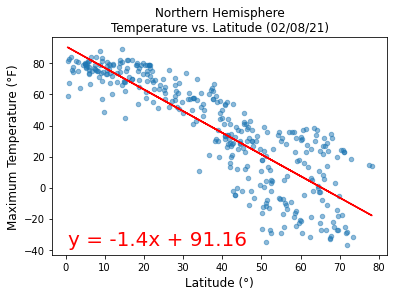

The r-value is: 0.73


In [42]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Max Temp',
    'Latitude (°)',
    'Maximum Temperature (°F)', 
    'Northern Hemisphere\nTemperature vs. Latitude',
    'NorthHemiSphere_TempVLat'
)

The data here shows us that there is a strong correlation between being closer to the equator and having a higher maximum temperature.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

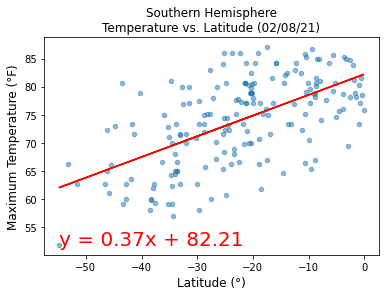

The r-value is: 0.36


In [43]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Max Temp',
    'Latitude (°)',
    'Maximum Temperature (°F)', 
    'Southern Hemisphere\nTemperature vs. Latitude',
    'SouthHemiSphere_TempVLat'
)

The data here shows us that there is a correlation between being closer to the equator and having a higher maximum temperature. We could probably infer that the axis of the earth has something to do with the variance seen in the data.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

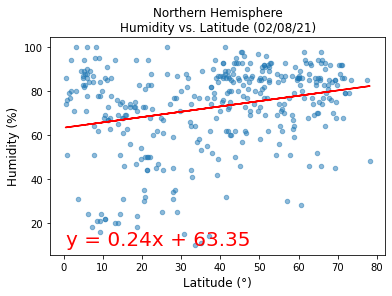

The r-value is: 0.07


In [44]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Humidity',
    'Latitude (°)',
    'Humidity (%)', 
    'Northern Hemisphere\nHumidity vs. Latitude',
    'NorthHemiSphere_HumidityVLat'
)

There seems to be little correlation in the humidity data, while it dose screw higher. Our data could be too vague with just using the latitude, this could prove more insightful if we had some way of plotting how close to water each point was.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

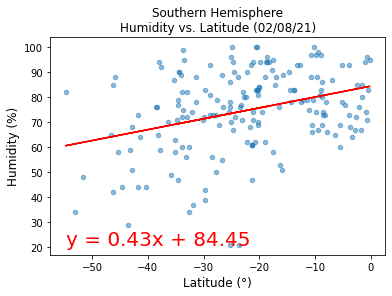

The r-value is: 0.11


In [45]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Humidity',
    'Latitude (°)',
    'Humidity (%)', 
    'Southern Hemisphere\nHumidity vs. Latitude',
    'SouthHemiSphere_HumidityVLat'
)

Like before, there seems to be little correlation in the humidity data, while it dose screw higher. Our data could be too vague with just using the latitude, this could prove more insightful if we had some way of plotting how close to water each point was.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

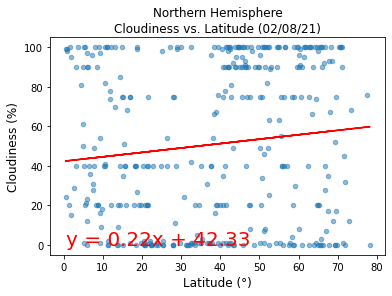

The r-value is: 0.01


In [46]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Cloudiness',
    'Latitude (°)',
    'Cloudiness (%)', 
    'Northern Hemisphere\nCloudiness vs. Latitude',
    'NorthHemiSphere_CloudinessVLat'
)

This data seems to be uncorrelated.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

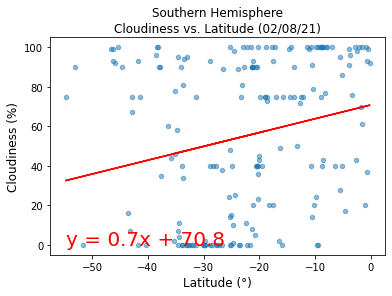

The r-value is: 0.05


In [47]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Cloudiness',
    'Latitude (°)',
    'Cloudiness (%)', 
    'Southern Hemisphere\nCloudiness vs. Latitude',
    'SouthHemiSphere_CloudinessVLat'
)

This data seems to be uncorrelated.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

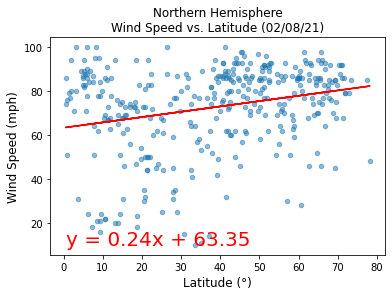

The r-value is: 0.07


In [48]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Wind Speed',
    'Latitude (°)',
    'Wind Speed (mph)', 
    'Northern Hemisphere\nWind Speed vs. Latitude',
    'NorthHemiSphere_WindSpeedVLat'
)

Like with the humidity, there seems to be little correlation in this data. But this plot is similar to the way the data of humidity plotted; they could have some deeper connections we just cannot see here.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

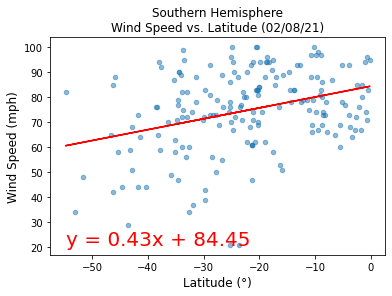

The r-value is: 0.11


In [49]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Wind Speed',
    'Latitude (°)',
    'Wind Speed (mph)', 
    'Southern Hemisphere\nWind Speed vs. Latitude',
    'SouthHemiSphere_WindSpeedVLat'
)

Like with the humidity, there seems to be little correlation in this data. But this plot is similar to the way the data of humidity plotted; they could have some deeper connections we just cannot see here.

# Observations

- With both the cities data and the Cities_TempVLat data and the North/SouthHemiSphere_TempVLat data, if all the data gathered in the city is assumed to be random, there is a skew in more data points being in the northern hemisphere. And this could track since a continent like Asia is primarily on the northern hemisphere.
- We can see a correlation with temperature vs latitude in both north and south, but it's more powerful in the north. This could be due to the axis of the earth creating either tighter data points if it is in the northern hemisphere, or creating more variance if it is in the southern hemisphere
- There seems to be little to no correlation in the hemisphere's to humidity and cloudiness. But their similarities in being plotted do point to a potential correlation within their data.